In [1]:
#Assignment 9
#Joint assimilation of navigation data coming from different sources
#Team 12
#Yaroslav Savotin, Elizaveta Pestova, Selamawit Asfaw
#Skoltech, 2023

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [82]:
def generate_Xt(x0, sigma_a, Fi, G, N):  
    ax = np.random.normal(0, np.sqrt(sigma_a), size = (1, 1, N))
    ay = np.random.normal(0, np.sqrt(sigma_a), size =(1, 1, N))
    
    A = np.zeros((2, 1, N))
    for i in range(N):
        A[0,0,i] = ax[0][0][i]
        A[1,0,i] = ay[0][0][i]
    
    Xt = np.zeros((4, 1, N))
    Xt[:, :, 0] = x0
    for i in range(1, N):
        Xt[:, :, i] = np.dot(Fi,Xt[:, :, i-1]) + np.dot(G,A[:, :, i-1])
    return Xt


def generate_DB(Xt,sigmaD, sigmaB_1Obs, sigmaB_2Obs, N):
    D = np.zeros((1, 1, N))
    Beta = np.zeros((1, 1, N))
    Dm = np.zeros((1, 1, N))
    Betam = np.zeros((1, 1, N))
      
    nuD = np.random.normal(0, np.sqrt(sigmaD), size =(1, 1, N))
    nuB_1 = np.random.normal(0, np.sqrt(sigmaB_1Obs), size =(1, 1, N))
    nuB_2 = np.random.normal(0, np.sqrt(sigmaB_2Obs), size =(1, 1, N))
    
    
    for i in range(N):
        D[:, :, i] = np.sqrt(Xt[0, 0, i]**2 + Xt[2, 0, i]**2)
        Beta[:, :, i] = np.arctan(Xt[0, 0, i] / Xt[2, 0, i])
        
        if i % 2 == 1:
            Dm[:, :, i] = np.nan
            Betam[:, :, i] = Beta[:, :, i] + nuB_1[:, :, i]
        else:
            Dm[:, :, i] = D[:, :, i] + nuD[:, :, i]
            Betam[:, :, i] = Beta[:, :, i] + nuB_2[:, :, i]
    return D, Beta, Dm, Betam

In [39]:
Zm1 = np.zeros((2, 1, N)) #measurement in !!!polar coordinates!!!
Zm2 = np.zeros((1, 1, N))
for i in range(N):
    Zm1[0, :, i] = Dm[:, :, i]
    Zm1[1, :, i] = Betam[:, :, i]
    Zm2[0, :, i] = Betam[:, :, i]

In [72]:
def Extended_kalmanFilter_1(R1, R2, X0, P0, Dm, Betam, Fi, Q, N):
    Zm1 = np.zeros((2, 1, N)) #measurement in !!!polar coordinates!!!
    Zm2 = np.zeros((1, 1, N))
    for i in range(N):
        Zm1[0, :, i] = Dm[:, :, i]
        Zm1[1, :, i] = Betam[:, :, i]
        Zm2[0, :, i] = Betam[:, :, i]
    
    Xf = np.zeros((4, 1, N)) #Filtration of state vector
    Pf = np.zeros((4, 4, N)) #Filtration error covariance matrix
    Xp = np.zeros((4, 1, N)) #Prediction of state vector
    Pp = np.zeros((4, 4, N)) #Prediction error covariance matrix
    
    Df = np.zeros((1, 1, N))
    Betaf = np.zeros((1, 1, N))
    Dp = np.zeros((1, 1, N))
    Betap = np.zeros((1, 1, N))
    
    K1 = np.zeros((4, 2, N)) #Filter gain
    K2 = np.zeros((4, 1, N))
    
    dh1 = np.zeros((2, 4, N)) #Derivative
    dh2 = np.zeros((1, 4, N))
    
    h1 = np.zeros((2, 1, N)) #Nonlinear function
    h2 = np.zeros((1, 1, N))
    
    Pf[:, :, 0] = P0
    Xf[:, :, 0] = X0
    
    #for i in range(2):
        ##Pf[:, :, i] = P0
        #Xf[:, :, i] = X0
    
    for i in range(N-2):
        #Prediction (extrapolation)
        Xp[:, :, i+2] = np.dot(Fi, Xf[:, :, i])
        
                #range D, azimuth Beta at every extrapolation step 
        Dp[:, :, i+2] = np.sqrt((Xp[0, :, i+2]**2) + (Xp[2, :, i+2]**2))
        Betap[:, :, i+2] = np.arctan(Xp[0, :, i+2] / Xp[2, :, i+2])
            
        Pp[:, :, i+2] = np.dot(np.dot(Fi, Pf[:, :, i]), np.transpose(Fi)) + Q
        
        #3,5,7...
        if i % 2 == 1:
            dh2[:, :, i+2] =  np.array([(Xp[2, 0, i+2]/(Xp[0, 0, i+2]**2+Xp[0, 0, i+2]**2)), 0, (-Xp[0, 0, i+2]/(Xp[0, 0, i+2]**2+Xp[2, 0, i+2]**2)), 0])
        
            h2[:, :, i+2] = Betap[:, :, i+2]

            #Filtration
                #Filter gain
            K2[:, :, i+2] = (np.dot(Pp[:, :, i+2], np.transpose(dh2[:, :, i+2])))/(np.dot(np.dot(dh2[:, :, i+2], Pp[:, :, i+2]), np.transpose(dh2[:, :, i+2])) + R2)
                #Improved estimate by incorporating a new measurement
            Xf[:, :, i+2] = Xp[:, :, i+2] + np.dot(K2[:, :, i+2], (Zm2[:, :, i+2] - h2[:, :, i+2]))
                #range D, azimuth Beta at every filtration step 
            Df[:, :, i+2] = np.sqrt((Xf[0, :, i+2]**2) + (Xf[2, :, i+2]**2))
            Betaf[:, :, i+2] = np.arctan(Xf[0, :, i+2] / Xf[2, :, i+2])

                #Filtration error covariance matri
            Pf[:, :, i+2] = np.dot((np.eye(4) - np.dot(K2[:, :, i+2], dh2[:, :, i+2])), Pp[:, :, i+2])
            
        #4,6,8...    
        else:
            dh1[:, :, i+2] = np.array([[(Xp[0, 0, i+2]/np.sqrt(Xp[0, 0, i+2]**2+Xp[2, 0, i+2]**2)), 0, (Xp[2, 0, i+2]/np.sqrt(Xp[0, 0, i+2]**2+Xp[2, 0, i+2]**2)), 0],
                            [(Xp[2, 0, i+2]/(Xp[0, 0, i+2]**2+Xp[0, 0, i+2]**2)), 0, (-Xp[0, 0, i+2]/(Xp[0, 0, i+2]**2+Xp[2, 0, i+2]**2)), 0]])
        
            h1[0, :, i+2] = Dp[:, :, i+2]
            h1[1, :, i+2] = Betap[:, :, i+2]

            #Filtration
                #Filter gain
            K1[:, :, i+2] = np.dot(np.dot(Pp[:, :, i+2], np.transpose(dh1[:, :, i+2])), np.linalg.inv(np.dot(np.dot(dh1[:, :, i+2], Pp[:, :, i+2]), np.transpose(dh1[:, :, i+2])) + R1))
                #Improv2ed estimate by incorporating a new measurement
            Xf[:, :, i+2] = Xp[:, :, i+2] + np.dot(K1[:, :, i+2], (Zm1[:, :, i+2] - h1[:, :, i+2]))
                #range D, azimuth Beta at every filtration step 
            Df[:, :, i+2] = np.sqrt((Xf[0, :, i+2]**2) + (Xf[2, :, i+2]**2))
            Betaf[:, :, i+2] = np.arctan(Xf[0, :, i+2] / Xf[2, :, i+2])

                #Filtration error covariance matri
            Pf[:, :, i+2] = np.dot((np.eye(4) - np.dot(K1[:, :, i+2], dh1[:, :, i+2])), Pp[:, :, i+2])

    return Xf, Xp, Dp, Betap, Df, Betaf,K1,K2

In [81]:
Xp[3]

array([[  0.        ,   0.        , 108.28426259,   0.        ,
         21.97454438,          nan, 132.40115922,          nan,
        176.05519184,          nan, 192.95870635,          nan,
        194.40869476,          nan, 198.75796406,          nan,
        195.91108959,          nan, 194.58937301,          nan,
        193.50351176,          nan, 192.08447931,          nan,
        191.43412236,          nan, 190.515152  ,          nan,
        190.15665652,          nan, 190.1399281 ,          nan,
        189.2827554 ,          nan, 188.70349188,          nan,
        188.87337024,          nan, 187.84939722,          nan,
        188.13035295,          nan, 187.58925184,          nan,
        187.35118639,          nan, 186.66333088,          nan,
        186.04664822,          nan, 185.19334958,          nan,
        185.19135152,          nan, 185.02360287,          nan,
        184.09297335,          nan, 182.63212844,          nan,
        181.81691039,          nan, 180.

In [75]:
Xf[0]

array([[ 1433.40299792,     0.        ,  1432.61449789,            nan,
         1705.92021197,            nan,  2140.25227956,            nan,
         2584.93778206,            nan,  3007.12681809,            nan,
         3447.63632345,            nan,  3825.52977711,            nan,
         4224.34412262,            nan,  4618.06368254,            nan,
         5003.02941261,            nan,  5394.15645254,            nan,
         5792.50752836,            nan,  6159.93897009,            nan,
         6555.01895391,            nan,  6928.15444039,            nan,
         7315.93198441,            nan,  7685.16126233,            nan,
         8069.24181447,            nan,  8452.19727462,            nan,
         8840.3184137 ,            nan,  9225.49877532,            nan,
         9619.47715601,            nan, 10014.11609047,            nan,
        10405.12285237,            nan, 10803.80201718,            nan,
        11192.54063532,            nan, 11593.86243458,         

In [74]:
#------------№1------------
# Initial conditions
N = 500 # Size of trajectory
step = np.arange(N)
T = 2 # interval between measurements

x0 = np.array([[1000], [100], [1000], [100]]) #Initial

sigma_a = 0.3**2  #Variance of noise

sigmaD = 50**2
sigmaB_firstObs = 0.004**2
sigmaB_secondObs = 0.001**2
#------------№5------------
# Transition Matrix
Fi = np.array([[1, T, 0, 0],
               [0, 1, 0, 0],
               [0, 0, 1, T],
               [0, 0, 0, 1]])
#--------------------------

# Input matrix
G = np.array([[(T**2)/2, 0],
              [T, 0],
              [0 ,(T**2)/2],
              [0, T]])

#Generate a true trajectory
Xt = generate_Xt(x0, sigma_a, Fi, G, N)
#------------№2,3, 4------------
#Generate true values of range D and azimuth Beta
#Generate measurements Dm, Betam for both observers
D, Beta, Dm, Betam = generate_DB(Xt,sigmaD, sigmaB_firstObs, sigmaB_secondObs, N)

#------------№5------------
#Initial conditions for Extended Kalman filter algorithm
#Initial filtered estimate of state vector X0,0
X0 = np.array([[Dm[0, 0, 2] * np.sin(Betam[0, 0, 2])],
              [(Dm[0, 0, 2] * np.sin(Betam[0, 0, 2]) - Dm[0, 0, 0] * np.sin(Betam[0, 0, 0])) / (2*T)],
              [Dm[0, 0, 2] * np.cos(Betam[0, 0, 2])],
              [(Dm[0, 0, 2] * np.cos(Betam[0, 0, 2]) - Dm[0, 0, 0] * np.cos(Betam[0, 0, 0])) / (2*T)]])


#Initial filtration error covariance matrix P0,0
P0 = np.array([[10**10, 0, 0, 0],
               [0, 10**10, 0, 0],
               [0, 0, 10**10, 0],
               [0, 0, 0, 10**10]])

#------------№6------------
#State noise covariance matrix
Q = np.dot(G,G.T)*sigma_a


#Measurement noise covariance
    #Observer 1, odd time steps
R1 = np.array([[sigmaD,0],
              [0,sigmaB_firstObs]])
    # Observer 2, even time steps
R2 = sigmaB_secondObs


Xf, Xp, Dp, Betap, Df, Betaf,K1,K2 = Extended_kalmanFilter_1(R1, R2, X0, P0, Dm, Betam, Fi, Q, N)

M = 500


C:\Users\silve\AppData\Local\Temp\ipykernel_18552\853660971.py:41: RuntimeWarning: invalid value encountered in divide
  Betap[:, :, i+2] = np.arctan(Xp[0, :, i+2] / Xp[2, :, i+2])
C:\Users\silve\AppData\Local\Temp\ipykernel_18552\853660971.py:47: RuntimeWarning: invalid value encountered in scalar divide
  dh2[:, :, i+2] =  np.array([(Xp[2, 0, i+2]/(Xp[0, 0, i+2]**2+Xp[0, 0, i+2]**2)), 0, (-Xp[0, 0, i+2]/(Xp[0, 0, i+2]**2+Xp[2, 0, i+2]**2)), 0])


In [35]:
Betam_plot =  np.zeros((1, 1, int(N/2)))
Dm_plot = Dm[~np.isnan(Dm)]
j = 0
for i in range(int(N/2)):
    Betam_plot[:, :, i] = Betam[:, :, j]
    j+=2

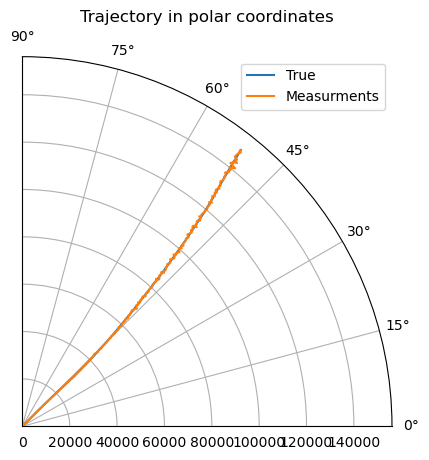

In [36]:
ax = plt.subplot(111, projection='polar')
ax.plot(Beta[0][0], D[0][0], label='True')
ax.plot(Betam_plot[0][0], Dm_plot, label='Measurments')
ax.set_title('Trajectory in polar coordinates')
ax.set_xlim(0,np.radians(90))
#ax.set_ylim(0,150000)
ax.legend()

plt.show()

In [37]:
Betam_plot =  np.zeros((1, 1, int(N/2)))
Dm_plot = Dm[~np.isnan(Dm)]
Dp[:, :, 3] = np.nan
Betap_plot =  Betap[~np.isnan(Betap)]
Dp_plot = Dp[~np.isnan(Dp)]

j = 0
for i in range(int(N/2)):
    Betam_plot[:, :, i] = Betam[:, :, j]
    j+=2

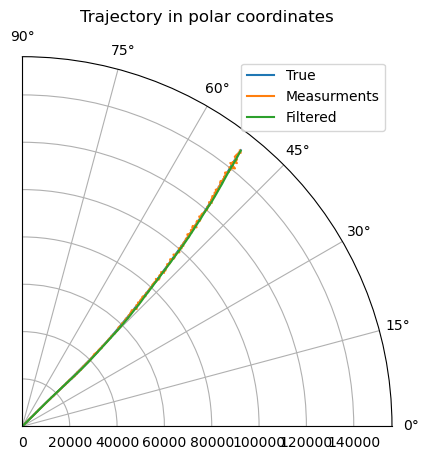

In [38]:
ax = plt.subplot(111, projection='polar')
ax.plot(Beta[0][0], D[0][0], label='True')
ax.plot(Betam_plot[0][0], Dm_plot, label='Measurments')
ax.plot(Betap_plot, Dp_plot, label='Filtered')
ax.set_title('Trajectory in polar coordinates')
ax.set_xlim(0,np.radians(90))
#ax.set_ylim(0,150000)
ax.legend()

plt.show()

In [10]:
#mean-squared error
MSE1, MSE2 = calculate_MSE(N, M, x0, sigma_a, sigmaD, sigmaB, Fi, G, Q, R, X0, P0)

NameError: name 'calculate_MSE' is not defined

In [11]:
# Plot
sigmaD_v = np.sqrt(sigmaD)*np.ones(N)
sigmaB_v = np.sqrt(sigmaB)*np.ones(N)

plt.plot(step, MSE1[0][0], label='estimation error')
plt.plot(step, MSE2[0][0], label='estimation error m steps')
plt.plot(step, sigmaD_v, label='Measurement error of Beta')
plt.title('Comparison of estimation results and measurement error of range D')
plt.xlabel('step')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'sigmaB' is not defined

In [12]:
plt.plot(step, MSE1[0][1], label='estimation error')
plt.plot(step, MSE2[0][1], label='estimation error m steps')
plt.plot(step, sigmaB_v, label='Measurement error of Beta')
plt.title('Comparison of estimation results and measurement error of range Beta')
plt.xlabel('step')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'step' is not defined

In [ ]:
def calculate_MSE(N, M, x0, sigma_a, sigmaD, sigmaB, Fi, G, Q, R1, R2, X0, P0):
    Error_run = np.zeros((2, M, N))
    final_Error = np.zeros((1, 2, N))
    Error_run1 = np.zeros((2, M, N))
    final_Error1 = np.zeros((1, 2, N))
    Pot = np.zeros((2, 1, N))
    Pof = np.zeros((2, 1, N))
    Pop = np.zeros((2, 1, N))
    
    for i in range(M):
        Xt = generate_Xt(x0, sigma_a, Fi, G, N)
        D, Beta, Dm, Betam = generate_DB(Xt,sigmaD, sigmaB, N)
        Xf, Dp, Betap, Df, Betaf = Extended_kalmanFilter(Fi, Q, R, X0, P0, Dm, Betam, N)
        
        for i in range(N):
            Pot[0,0,i] = D[0][0][i]
            Pot[1,0,i] = Beta[0][0][i]
            
            Pof[0,0,i] = Df[0][0][i]
            Pof[1,0,i] = Betaf[0][0][i]
            
            Pop[0,0,i] = Dp[0][0][i]
            Pop[1,0,i] = Betap[0][0][i]
        
        for j in range(N):
            Error_run[:, i, j] = ((Pot[:, :, j] - Pof[:, :, j]) ** 2).T
            Error_run1[:, i, j] = ((Pot[:, :, j] - Pop[:, :, j]) ** 2).T
    
    for i in range(N):
        for k in range(M):
            final_Error[:, :, i] += Error_run[:, k, i]
            final_Error1[:, :, i] += Error_run1[:, k, i]
        
        final_Error[:, :, i] = np.sqrt(final_Error[:, :, i] / (M - 1))
        final_Error1[:, :, i] = np.sqrt(final_Error1[:, :, i] / (M - 1))
             
    return final_Error, final_Error1

In [ ]:
def Extended_kalmanFilter_1(R1, R2, X0, P0, Dm, Betam, Fi, Q, N):
    Zm1 = np.zeros((2, 1, N)) #measurement in !!!polar coordinates!!!
    Zm2 = np.zeros((1, 1, N))
    for i in range(N):
        Zm1[0, :, i] = Dm[:, :, i]
        Zm1[1, :, i] = Betam_1[:, :, i]
        Zm2[0, :, i] = Betam_2[:, :, i]
    
    Xf = np.zeros((4, 1, N)) #Filtration of state vector
    Pf = np.zeros((4, 4, N)) #Filtration error covariance matrix
    Xp = np.zeros((4, 1, N)) #Prediction of state vector
    Pp = np.zeros((4, 4, N)) #Prediction error covariance matrix
    
    Df = np.zeros((1, 1, N))
    Betaf = np.zeros((1, 1, N))
    Dp = np.zeros((1, 1, N))
    Betap = np.zeros((1, 1, N))
    
    K1 = np.zeros((4, 2, N)) #Filter gain
    K2 = np.zeros((4, 1, N))
    
    dh1 = np.zeros((2, 4, N)) #Derivative
    dh2 = np.zeros((1, 4, N))
    
    h1 = np.zeros((2, 1, N)) #Nonlinear function
    h2 = np.zeros((1, 1, N))
    
    Pf[:, :, 3] = P0
    Xf[:, :, 3] = X0
    
    for i in range(3,N-2):
        #odd steps
        if i % 2 == 0:
            #Prediction (extrapolation)
            Xp[:, :, i+2] = np.dot(Fi, Xf[:, :, i])
        
                #range D, azimuth Beta at every extrapolation step 
            Dp[:, :, i+2] = np.sqrt((Xp[0, :, i+2]**2) + (Xp[2, :, i+2]**2))
            Betap[:, :, i+2] = np.arctan(Xp[0, :, i+2] / Xp[2, :, i+2])
        
                #Derivative
                #x = D*sinB
                #y = D*cosB
                #Substituting into the Derivative equations and it turns out:
            dh1[:, :, i+2] = np.array([[np.sin(Betap[:, :, i+2][0][0]), 0, np.cos(Betap[:, :, i+2][0][0]), 0],
                                [np.cos(Betap[:, :, i+2][0][0])/Dp[:, :,i+2][0][0], 0, -np.sin(Betap[:, :,i+2][0][0])/Dp[:, :,i+2][0][0], 0]])

            Pp[:, :, i+2] = np.dot(np.dot(Fi, Pf[:, :, i]), np.transpose(Fi)) + Q

            h1[0, :, i+2] = Dp[:, :, i+2]
            h1[1, :, i+2] = Betap[:, :, i+2]

            #Filtration
                #Filter gain
            K1[:, :, i+2] = np.dot(np.dot(Pp[:, :, i+2], np.transpose(dh1[:, :, i+2])), np.linalg.inv(np.dot(np.dot(dh1[:, :, i+2], Pp[:, :, i+2]), np.transpose(dh1[:, :, i+2])) + R1))
                #Improved estimate by incorporating a new measurement
            Xf[:, :, i+2] = Xp[:, :, i+2] + np.dot(K1[:, :, i+2], (Zm1[:, :, i+2] - h1[:, :, i+2]))
                #range D, azimuth Beta at every filtration step 
            Df[:, :, i+2] = np.sqrt((Xf[0, :, i+2]**2) + (Xf[2, :, i+2]**2))
            Betaf[:, :, i+2] = np.arctan(Xf[0, :, i+2] / Xf[2, :, i+2])

                #Filtration error covariance matri
            Pf[:, :, i+2] = np.dot((np.eye(4) - np.dot(K1[:, :, i+2], dh1[:, :, i+2])), Pp[:, :, i+2])
        #even steps    
        else:
            #Prediction (extrapolation)
            Xp[:, :, i+2] = np.dot(Fi, Xf[:, :, i])
        
                #range D, azimuth Beta at every extrapolation step 
            Dp[:, :, i+2] = np.sqrt((Xp[0, :, i+2]**2) + (Xp[2, :, i+2]**2))
            Betap[:, :, i+2] = np.arctan(Xp[0, :, i+2] / Xp[2, :, i+2])
        
                #Derivative
                #x = D*sinB
                #y = D*cosB
                #Substituting into the Derivative equations and it turns out:
            dh2[:, :, i+2] = np.array([[np.cos(Betap[:, :, i+2][0][0])/Dp[:, :, i+1][0][0], 0, -np.sin(Betap[:, :, i+2][0][0])/Dp[:, :, i+1][0][0], 0]])

            Pp[:, :, i+2] = np.dot(np.dot(Fi, Pf[:, :, i]), np.transpose(Fi)) + Q

            h2[:, :, i+2] = Betap[:, :, i+2]

            #Filtration
                #Filter gain
            K2[:, :, i+2] = (np.dot(Pp[:, :, i+2], np.transpose(dh2[:, :, i+2])))/(np.dot(np.dot(dh2[:, :, i+2], Pp[:, :, i+2]), np.transpose(dh2[:, :, i+2])) + R2)
                #Improved estimate by incorporating a new measurement
            Xf[:, :, i+2] = Xp[:, :, i+2] + np.dot(K2[:, :, i+2], (Zm2[:, :, i+2] - h2[:, :, i+2]))
                #range D, azimuth Beta at every filtration step 
            Df[:, :, i+2] = np.sqrt((Xf[0, :, i+2]**2) + (Xf[2, :, i+2]**2))
            Betaf[:, :, i+2] = np.arctan(Xf[0, :, i+2] / Xf[2, :, i+2])

                #Filtration error covariance matri
            Pf[:, :, i+2] = np.dot((np.eye(4) - np.dot(K2[:, :, i+2], dh2[:, :, i+2])), Pp[:, :, i+2])

    return Xf, Dp, Betap, Df, Betaf